# Assignment 2: Natural Language Processing

_Course: 02805 - **Social Graphs and Interactions**_ <br>
_Course responsible: **Sune Lehmann Jørgensen**_ <br>
_DTU - **Technical University of Denmark**_

---

## Table of Contents:

- [__Part 1: Network visualization & descriptive statistics__](#1.)
    
    - [1.1. <u>Building network</u>](#1.1.)
    - [1.2. <u>Statistics</u>](#1.2.)
    - [1.3. <u>Visualization</u>](#1.3.)
    

- [__Part 2: Wordclouds for each comic universe__](#2.)

- [__Part 3: Community detection & TF-IDF Wordclouds__](#3.)

- [__Part 4: Sentiment analysis of communities__](#4.)

---

#### Importing the necessary libraries:

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import math
import random
import os

import collections
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
# Network libraries
import networkx as nx
from fa2 import ForceAtlas2 as FA2
import community

In [3]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import glob
import re
import string as StringLibrary

---

<a id='1.'></a>
## Part 1: Network visualization & descriptive statistics

**Exercise 1**: Visualize the network (from lecture 5) and calculate basic stats (from lecture 4). For this exercise, we assume that you've already generated the network of superheroes, report work on the giant connected component.

<a id='1.1.'></a>
### 1.1. Building network

Let us first create the "Comics" universe members from loading csv files which contain the character names and its corresponding wikilinks, and store these interanctions into a directed graph:

In [4]:
df_marvel = pd.read_csv('marvel_characters.csv', sep = '|', index_col = 0, keep_default_na = False)
df_dc = pd.read_csv('dc_characters.csv', sep = '|', index_col = 0, keep_default_na = False)
df_dc = df_dc.rename(columns = {'WikiLink;' : 'WikiLink'}, inplace = False)
df_dc['WikiLink'] = df_dc['WikiLink'].str.strip(';')

Now, we will create the Comics network as a directed graph:

In [7]:
# Create the Comics network as a directed graph
comics_graph = nx.DiGraph()

In [8]:
# Add nodes and with data (character name & universe)

# For MARVEL
for character_name in df_marvel['CharacterName']:
    comics_graph.add_node(character_name)
     
    # define universe
    comics_graph.nodes[character_name]['universe'] = 'marvel'
    
# For DC
for character_name in df_dc['CharacterName']:
    comics_graph.add_node(character_name)

    # define universe
    comics_graph.nodes[character_name]['universe'] = 'dc'

In [9]:
# Funtion for adding the links/references between the characters to the graph
def link_input(df, path_name, graph):
    for character_name_in in df['CharacterName']:

        # Load the page of the superhero, in a try-except clause for error catching
        try:
            with open(path_name + character_name_in + '.txt', 'r', encoding = 'utf8') as wiki_page:
                page = wiki_page.read()

            # Get all the reference links on the page (using regex)
            links = re.findall('\[{2}((?!.+?:)([^\]\[]+)\|([^\]\[]+)|([^\|]+?))\]{2}', page)
            reference_links = [(tuple(int(x) if x.isdigit() else x for x in _ if x)) for _ in links]

            for i in range(len(reference_links)):

                for character_name_out in df['CharacterName']:
                    if character_name_out == reference_links[i][0]:
                        # Add edge 1 by 1
                        graph.add_edge(character_name_in, reference_links[i][0])
        except:
            pass
        
    return graph

In [10]:
comics_graph = link_input(df=df_dc, path_name='./data/dc/', graph=comics_graph)
comics_graph = link_input(df=df_marvel, path_name='./data/marvel/', graph=comics_graph)

Lastly, we have to remember that our work should be done only on the GCC (giant connected component), meaning that it is also reasonable to remove the isolated nodes in this graph:

In [11]:
# Remove the isolated nodes from the graph
comics_graph.remove_nodes_from(list(nx.isolates(comics_graph)))

Let us now remove the (very) small connected components (from the undirected version of this graph), so that we are left with only the GCC:

In [12]:
for component in list(nx.connected_components(comics_graph.to_undirected())):
    if (len(component) < 5):
        for node in component:
            comics_graph.remove_node(node)

Our network is now modeled, and we are ready to perform statistics and visualisation upon it.

<a id='1.2.'></a>
### 1.2. Statistics

* What is the number of nodes in the network?

In [13]:
print("The number of nodes in the Comics network is:", comics_graph.number_of_nodes())

The number of nodes in the Comics network is: 2676


* What is the number of links?

In [14]:
print("The number of links in the Comics network is:", comics_graph.number_of_edges())

The number of links in the Comics network is: 22534


* What is the number of links connecting Marvel and DC? Explain in your own words what those links mean.

We will find the total number of directed links which connect the two universes below. 

Since this is a directed graph, we do not need to worry about counting links twice, since, in this case, every link will be unique due to its direction.

In [15]:
number_of_links_between_universes = 0

for node_1_name, node_2_name in list(comics_graph.edges()):
    
    # Retrieve the universe of the outgoing node (#1)
    node_1_universe = comics_graph.nodes[node_1_name]['universe']
    
    # Retrieve the universe of the receiving node (#2)
    node_2_universe = comics_graph.nodes[node_2_name]['universe']
    
    # If the unique link is happening between two universes, then increment the total number of such links found
    if (node_1_universe != node_2_universe):
        number_of_links_between_universes += 1

In [16]:
print("The number of links between the two universes is:", number_of_links_between_universes)

The number of links between the two universes is: 162


<span style="color:blue">The links which we found to connect the two universes are representing cross-overs between the different universes. This happens most likely when two comic book creators or authors decide to collaborate, or reward fans with such events. </span>

* Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected.

First, we have to find the list of in- and out-degrees for each character individually, before we show the 5 most connected ones:

In [17]:
# Here, we sort all the nodes of the Comics network by their 'IN' degree

# The 'key' attribute of the sorted() function must be callable (i.e. lambda function), and shows what should we sort the list by. 
# In our case, we should sort the list by the second element of each tuple in the list, which is actually the "in-degree" value
connected_nodes_in_list = sorted(dict(comics_graph.in_degree()).items(), key = lambda x: x[1], reverse = True)

In [18]:
# Here, we sort all the nodes of the Comics network by their 'OUT' degree

# Exactly the same as previously
connected_nodes_out_list = sorted(dict(comics_graph.out_degree()).items(), key = lambda x: x[1], reverse = True)

Here, we present the 5 characters with the most "in"-links, which means that other characters refer to those within their Wiki pages.

In [19]:
for character, in_degree in connected_nodes_in_list[:5]:
    node = comics_graph.nodes[character]
    print(character.ljust(25), 'In-degree:', str(in_degree))

Superman                  In-degree: 565
Batman                    In-degree: 560
Spider-Man                In-degree: 467
Captain America           In-degree: 393
Wonder Woman              In-degree: 336


<span style="color:blue">This is exactly as we would have expected, since the in-degree refers to the number of nodes/characters which "mention you", meaning that the most popular characters across Marvel & DC should be the ones with the highest in-degrees. Superman, Batman, and all the other 3 characters here are widely known main-characters, and most other characters in the comic universes link to them as supporting or antagonist characters.</span>

Let us also present the 5 characters with most "out"-links, meaning that they have most references to other characters.

In [20]:
for character, out_degree in connected_nodes_out_list[:5]:
    node = comics_graph.nodes[character]
    print(character.ljust(25), 'Out-degree:', str(out_degree))

Beast                     Out-degree: 63
Brute                     Out-degree: 63
Barracuda (II)            Out-degree: 63
Jackal                    Out-degree: 62
Belthera, Queen           Out-degree: 51


<span style="color:blue">These characters are having the largest number of direct outgoing connections to other members of the universes. This means that they are most likely recurring cast of the series, which serve a supporting role, and have met many other characters throughout the comic book volumes. These characters are clearly less popular than the ones we have seen in the list above, therefore, it is hard to say whether they were expected or not, however a long-term comic book fan could probably confirm these findings.</span>

* Plot the in and out-degree distributions. 

Let us plot the in-degree distribution, in linear and log-log scale, using `np.histogram`:

In [21]:
# Here, we have discarded the nodes with degree 0
in_degree_list = [x[1] for x in list(comics_graph.in_degree()) if x[1] != 0]

max_in_degree = max(in_degree_list)
min_in_degree = min(in_degree_list)

print('The maximum in-degree in our network is:', max_in_degree)
print('The minimum in-degree in our network is:', min_in_degree)

The maximum in-degree in our network is: 565
The minimum in-degree in our network is: 1


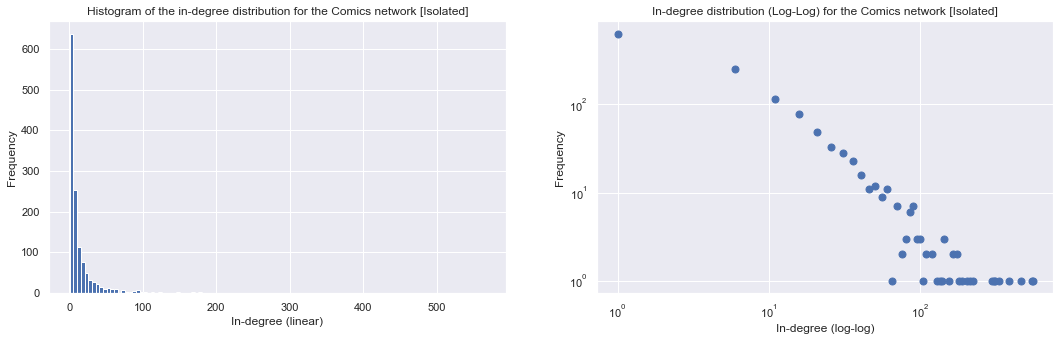

In [22]:
hist, bins = np.histogram(in_degree_list, bins = len(set(in_degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(in_degree_list, bins = bins, ec = "white")
axs[0].set_title('Histogram of the in-degree distribution for the Comics network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 100));
axs[0].set_xlabel('In-degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('In-degree distribution (Log-Log) for the Comics network [Isolated]')
axs[1].set_xlabel('In-degree (log-log)')
axs[1].set_ylabel('Frequency');

Now, we will do the same for the out-degree distribution:

In [23]:
out_degree_list = [x[1] for x in list(comics_graph.out_degree()) if x[1] != 0]

max_out_degree = max(out_degree_list)
min_out_degree = min(out_degree_list)

print('The maximum out-degree in our network is:', max_out_degree)
print('The minimum out-degree in our network is:', min_out_degree)

The maximum out-degree in our network is: 63
The minimum out-degree in our network is: 1


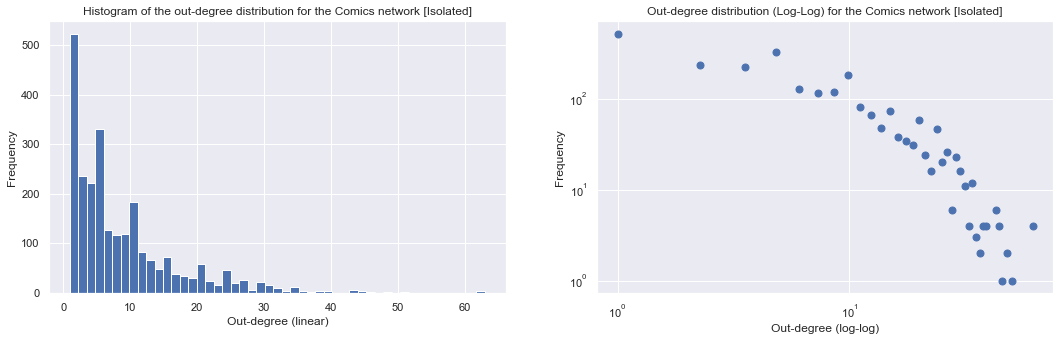

In [24]:
hist, bins = np.histogram(out_degree_list, bins = len(set(out_degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(out_degree_list, bins = bins, ec = "white")
axs[0].set_title('Histogram of the out-degree distribution for the Comics network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 100));
axs[0].set_xlabel('Out-degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('Out-degree distribution (Log-Log) for the Comics network [Isolated]')
axs[1].set_xlabel('Out-degree (log-log)')
axs[1].set_ylabel('Frequency');

* Explain what you observe? 

<span style="color:blue">It seems that the in-degree distribution follows a power-law distribution, much like a scale-free network. It can be clearly seen from the plot and the printing of the max/min in-degree values that there are a select few "hub" nodes which recieve a very large amount of connections from other characters, while most of the network is actually connected only with very few other nodes $(d_{in} < 100)$.</span>

<br>

<span style="color:blue">For the out-degree distribution, it is more tricky. It doesn't seem to be a pure power law, since there are "uneven" local peaks in the degree distribution, however it seems that it still behaves largely according to the power-law rules, albeit in a "toned down" manner. The scale of out-degrees decreases as frequency increases, although not as rapidly as we've seen previously. There still seems to be an outgoing link "hub", with more than 60 outgoing connections.</span>

* Explain why the in-degree distribution is different from the out-degree distribution?

<span style="color:blue">The in-degree distribution behaves largely different than the out-degree one, since the in-degree distribution is a direct measure of importance and popularity within the comic book universes, meaning that the more characters connect with a node, the more important that node is to a universe, since it probably means that most volumes published contained the node in its writing. On the other hand, the out-degree distribution refers to how many connections a particular node directly links to. High values for this would probably mean that a character directly influences a number of other characters' stories, which is usually the case for supporting characters, for example.</span>

<br>

<span style="color:blue">It seems very normal the number of in-links of a node would generally be higher than its out-links. This is a fact that can also be seen from the scale of the two plots, since the "in-links" are aggregating all the Wiki mentions across the character pages from the website, whereas "out-links" are relating just to one single Wiki page (that of the character itself). We would expect an aggregation across 2000+ pages to give a larger number of mentions than the number of links can normally can be written about within one single page.</span>

* Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$. Comment or your results.

The network that we will compare against is a __directed Erdős-Rényi (random) graph__, with a value of $p$ computed by calculation upon all the degrees (i.e. combining the in- and out-degree values, and using the final result to compute $p$).

Let us first compute $p$ below, knowing that $p = \frac{<k>}{N-1}$:

In [25]:
# Calculate the average of all degrees in the directed graph
k = np.mean([x[1] for x in list(comics_graph.degree())])

# N is the total number of nodes
N = comics_graph.number_of_nodes()

In [26]:
p = k / (N - 1)
print('The value of "p" is:', p)

The value of "p" is: 0.006295908246371345


Now, let us generate the directed random network:

In [27]:
directed_random_graph = nx.fast_gnp_random_graph(n = N, p = p, seed = 3, directed = True)

Finally, let us take a look at the in- and out-degree distribution for the random network, and see how it compares with the previous results from our Comics network:

In [28]:
# Here, we have discarded the nodes with degree 0
in_degree_list = [x[1] for x in list(directed_random_graph.in_degree()) if x[1] != 0]

max_in_degree = max(in_degree_list)
min_in_degree = min(in_degree_list)

print('The maximum in-degree in the random network is:', max_in_degree)
print('The minimum in-degree in the random network is:', min_in_degree)

The maximum in-degree in the random network is: 32
The minimum in-degree in the random network is: 5


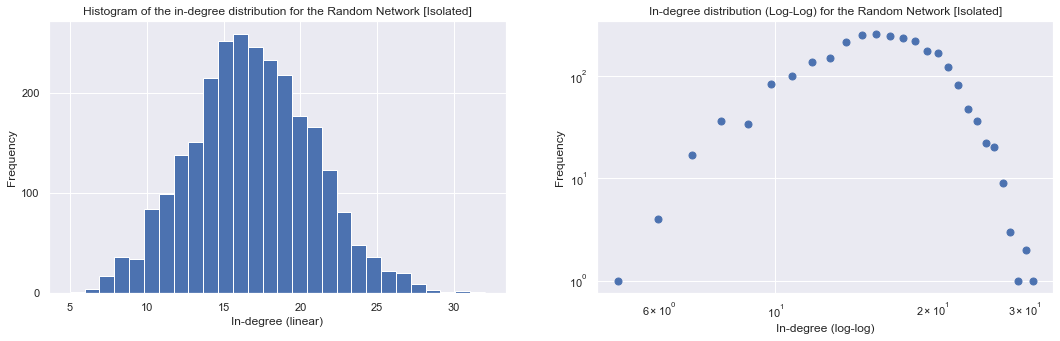

In [29]:
hist, bins = np.histogram(in_degree_list, bins = len(set(in_degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(in_degree_list, bins = bins, ec = "white")
axs[0].set_title('Histogram of the in-degree distribution for the Random Network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 100));
axs[0].set_xlabel('In-degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('In-degree distribution (Log-Log) for the Random Network [Isolated]')
axs[1].set_xlabel('In-degree (log-log)')
axs[1].set_ylabel('Frequency');

In [30]:
out_degree_list = [x[1] for x in list(directed_random_graph.out_degree()) if x[1] != 0]

max_out_degree = max(out_degree_list)
min_out_degree = min(out_degree_list)

print('The maximum out-degree in the random network is:', max_out_degree)
print('The minimum out-degree in the random network is:', min_out_degree)

The maximum out-degree in the random network is: 30
The minimum out-degree in the random network is: 4


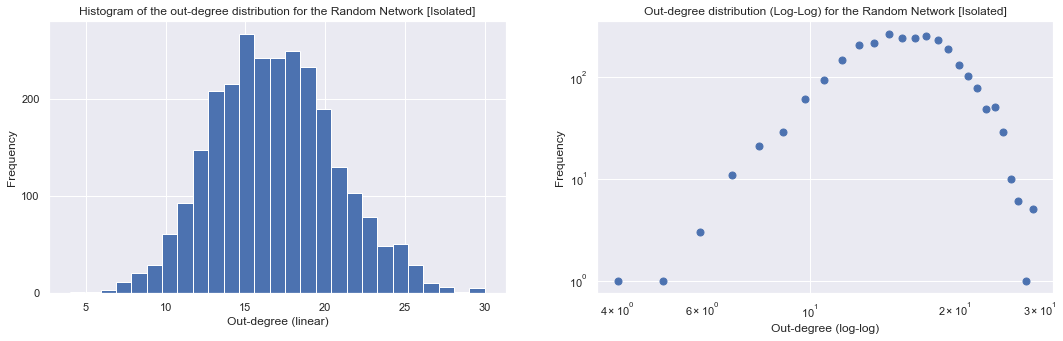

In [31]:
hist, bins = np.histogram(out_degree_list, bins = len(set(out_degree_list)))

fig, axs = plt.subplots(1, 2, figsize = (18, 5))

counts = axs[0].hist(out_degree_list, bins = bins, ec = "white")
axs[0].set_title('Histogram of the out-degree distribution for the Random Network [Isolated]')
axs[0].set_yticks(ticks = range(0, max(hist) + 1, 100));
axs[0].set_xlabel('Out-degree (linear)')
axs[0].set_ylabel('Frequency')

axs[1].loglog(bins[:-1], hist, 'bo', markersize = 7)
axs[1].set_title('Out-degree distribution (Log-Log) for the Random Network [Isolated]')
axs[1].set_xlabel('Out-degree (log-log)')
axs[1].set_ylabel('Frequency');

<span style="color:blue">For both the in- and the out-degree distributions of the directed random network, we can approximate the degree distributions found with a Poisson distribution centered unimodally. This is unlike our scale-free behaving Comics network, where the distributions seemed to resemble a power law much more.</span>
    
<span style="color:blue">It is worth noting that, since this is a randomly-generated network, there is much more of a balance between the scaling of the out-degree and in-degree values (which are actually being at identical scale). This behaviour is to be expected from a network which generates the $n(n-1)$ possible directed edges with a probability $p$, however this situation would be unlikely in networks acting at least similarily to a scale-free manner, such as our Comics graph.</span>

<a id='1.3.'></a>
### 1.3. Visualization

* Create a nice visualization of the total network.
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

In [96]:
# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100)

First of all, let us calculate the most appropriate positions for the nodes of the _undirected_ Comics network graph, using the Force Atlas method:

In [97]:
# Calculate positions of nodes in the visualization
positions = forceatlas2.forceatlas2_networkx_layout(comics_graph.to_undirected(), pos = None, iterations = 1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.63it/s]

BarnesHut Approximation  took  20.52  seconds
Repulsion forces  took  91.94  seconds
Gravitational forces  took  0.29  seconds
Attraction forces  took  0.38  seconds
AdjustSpeedAndApplyForces step  took  1.20  seconds


After we have found the most appropriate positions for every node in the graph, let us also make a color according to the universe, as well as, a node scaling based on the universe that the nodes are belonging to:

In [98]:
character_color_dict = {}

# For every node in this community, we assign them the previously-computed random color
for entry in comics_graph.nodes(data = True):
    
    # Extract the data about the node
    name = entry[0]
    universe = entry[1]['universe']
    
    if (universe == 'marvel'):
        character_color_dict[name] = 'gold'
    elif (universe == 'dc'):
        character_color_dict[name] = 'skyblue'
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_colors = []
# At the same time, we will create a list of node sizes by looking directly at the total degree of each individual node
node_sizes = []

for node in comics_graph:
    # Append the appropriate color to a node
    node_colors.append(character_color_dict[node])
    
    # Append the appropriate size to a node
    node_sizes.append(comics_graph.degree(node) * 0.4)

Finally, let us visualize the graph (using the Force-Atlas method):

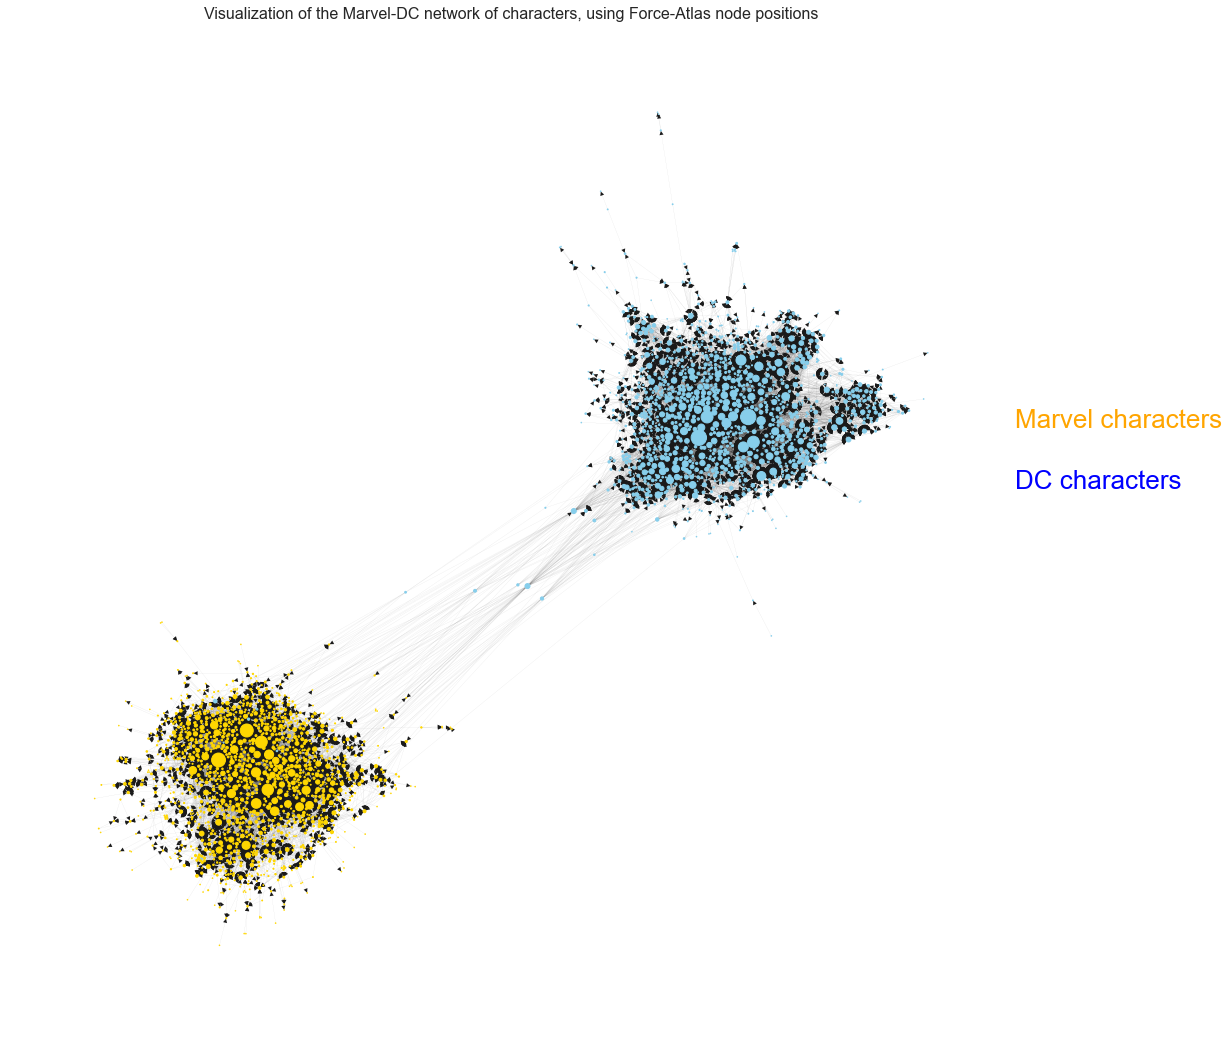

In [99]:
plt.figure(figsize = (14, 14))

nx.draw(comics_graph, pos = positions, node_size = node_sizes, node_color = node_colors, width = 0.025)

plt.figtext(1, 0.60, 'Marvel characters', size = 26, color = 'orange')
plt.figtext(1, 0.54, 'DC characters', size = 26, color = 'blue')

plt.title("Visualization of the Marvel-DC network of characters, using Force-Atlas node positions", fontsize = 16);

<span style="color:blue">The visualization has made use of the Force Atlas algorithm in order to spatialize the _undirected_ version of the Comics network, and the positions retrieved from the algorithm have been used here, together with a color and size separation for each individual node/character in the network. We can see that there is indeed a "feeling" of community splitting already from within this full network graph, where most characters from one universe interact only with other members from the same universe.</span>

<span style="color:blue">The black spots in the graph are actually resulting from the directed arrows going into and out of nodes, since the Force-Atlas algorithm does not account for this in its calculations of node positions.</span>

---

<a id='2.'></a>
## Part 2: Wordclouds for each comic universe

**Exercise 2**: Create your own version of the TF-TR word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the wiki-pages.

In order to create the wordclouds from our two sets of universes, we must first create the corpus of text from each universe in part:

In [37]:
dc_file_list = glob.glob(os.path.join(os.getcwd(), "data/dc", "*.txt"))
marvel_file_list = glob.glob(os.path.join(os.getcwd(), "data/marvel", "*.txt"))

In [38]:
corpus_dc = []
corpus_marvel = []

for path in dc_file_list:
    with open(path, encoding = 'utf-8') as file:
        corpus_dc.append(file.read())

for path in marvel_file_list:
    with open(path, encoding = 'utf-8') as file:
        corpus_marvel.append(file.read())

In [39]:
# Concatenate into one big string for both corpus
corpus_dc_string = ' '.join(corpus_dc)
corpus_marvel_string = ' '.join(corpus_marvel)

The function below is responsible for the text parsing and cleaning, including operations such as:

* Tokenizing (separating long text into words/tokens)
* Removing punctuation and numbers
* Removing stopwords (very frequenct English auxiliary words with no meaningful value)
* Basic stemming (removing suffixes from words)
* Lemmatization (removing conjugations from words and keeping them in base dictionary form)

In [40]:
def cleaning_text_corpus(corpus_str):
    
    # Tokenize the corpuses 
    tokens_list = nltk.word_tokenize(corpus_str)
    
    # Remove all non-alphabetic tokens and set all remaining tokens to lower case
    words_list = [w.lower() for w in tokens_list if w.isalpha()]
    
    # Remove stopwords
    stopwords_set = set(stopwords.words('english'))
    no_sw_words_list = [w for w in words_list if w not in stopwords_set]
    
    # Stemming
    def stem(word):
        regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
        stem, suffix = re.findall(regexp, word)[0]
        return stem
    stemmed_words_list = [stem(w) for w in no_sw_words_list]
    
    # Lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    clean_words_list = [lemmatizer.lemmatize(w) for w in stemmed_words_list]
    
    return clean_words_list

After the original corpus of text is read for both universes, we must clean it accordingly, to make it ready for a nice visualization:

In [41]:
wordlist_dc = cleaning_text_corpus(corpus_dc_string)
wordlist_marvel = cleaning_text_corpus(corpus_marvel_string)

Now, we compute the term frequency for each word, which is simply a frequency count for each of the words:

In [42]:
# Create TF list (term frequency)
TF_dc = nltk.FreqDist(wordlist_dc)
TF_marvel = nltk.FreqDist(wordlist_marvel)

Using the function below, we will compute the TF-TR ranking for each of the words.

<font color='blue'>Term frequency suggests how frequent a word occurs in general, but it is not able to distinguish the words that are unique to different corpora or universes, since the most frequent words will end up showing in all the corpora.</font>
   
<font color='blue'>Therefore, we would like to implement a _term ratio_, which represents the ratio of frequency across universes for every word, to assign a weight to the words.</font>
    
<font color='blue'>In this way, if one word is occurring frequently both in universe A as well as in universe B, the ratio would help diminish its importance; On the hand, if a word only appears significantly alot in one universe (unique to that universe) but not in the other, it would be assigned a high weight for that particular universe, thereby it will be ranked higher.</font>

<font color='blue'>The weights for the words are calculated using the following expressions: </font>

$$w_{t}^{(m)} = \frac{\textrm{TF}^{(m)}_t}{ \textrm{TF}^{(d)}_t + c}, \qquad \textrm{and} \qquad w_{t}^{(d)} = \frac{\textrm{TF}^{(d)}_t}{ \textrm{TF}^{(m)}_t + c}. \qquad \textrm{where} \quad m = Marvel, d = DC$$ 

<font color ='blue'> The TF-TR value for each word will then be calculated as: </font>
    
$$\textrm{TF}^{(u)}_t \times w_{t}^{(u)}, \qquad \textrm{where} \quad u \in \{m,d\}$$
    
<font color='blue'> In order to avoid that a word occurs 0 times or in other words the situation of dividing by 0, we are adding a constant $c$ to the denominator of the weight calculation formula. Different values of this constant would influece the ratio differently:  </font>

* <font color='blue'> Large constant: it will shrink the difference in word weights for the different universes; </font>

* <font color='blue'> Small constant: it will not influence the weight significantly; </font>

In [43]:
# Function for generating the TF-TR dictionaries
def TFTR_ranking(c, tf_dict_main, tf_dict_secondary):
    term_rank = {}
    
    for key in tf_dict_main.keys():
        
        # Get frequency
        freq_main = tf_dict_main.get(key)
        freq_secondary = tf_dict_secondary.get(key)
        
        if (freq_main == None):
            freq_main = 0
            
        if (freq_secondary == None):
            freq_secondary = 0
            
        # Compute ratio of a word
        ratio = freq_main / (freq_secondary + c)
        # Compute rank of a word
        rank = freq_main * ratio
        
        term_rank[key] = rank
        
    return term_rank

We will apply our TF-TR ranking function to the cleaned word dataset, for each universe in part:

In [44]:
TFTR_dc = TFTR_ranking(c = 1, tf_dict_main = dict(TF_dc), tf_dict_secondary = dict(TF_marvel))
TFTR_marvel = TFTR_ranking(c = 1, tf_dict_main = dict(TF_marvel), tf_dict_secondary = dict(TF_dc))

In [45]:
# Function for converting the word dictionary into a string
def dict_to_string(word_dict, shrink=True):
    
    total_string = ''
    
    for word in word_dict:
        
        # If the counts of words are too large, we divide the original count by 100 for computing faster
        if shrink==True:
            repeat_nr = math.ceil(word_dict[word] / 100)
        
        else:
            repeat_nr = math.ceil(word_dict[word])
        
        # Create a string of one term (occuring, in a proportional manner, according to the TF-TR scores)
        string = ''.join([word+' ' for count in range(repeat_nr)])
        
        # Concatenate the current elements to the total string
        total_string += string
        
    return total_string

Lastly, using the function above, the list of tokens will be converted back to a long string, with as many duplicates of a word as its _term rank_ (in reality, we chose to divide the number by 100 to allow reasonable code runtimes):

In [46]:
string_dc = dict_to_string(TFTR_dc)
string_marvel = dict_to_string(TFTR_marvel)

The wordclouds are drawn on a high-resolution plot, with color sets differentiating the two universes:

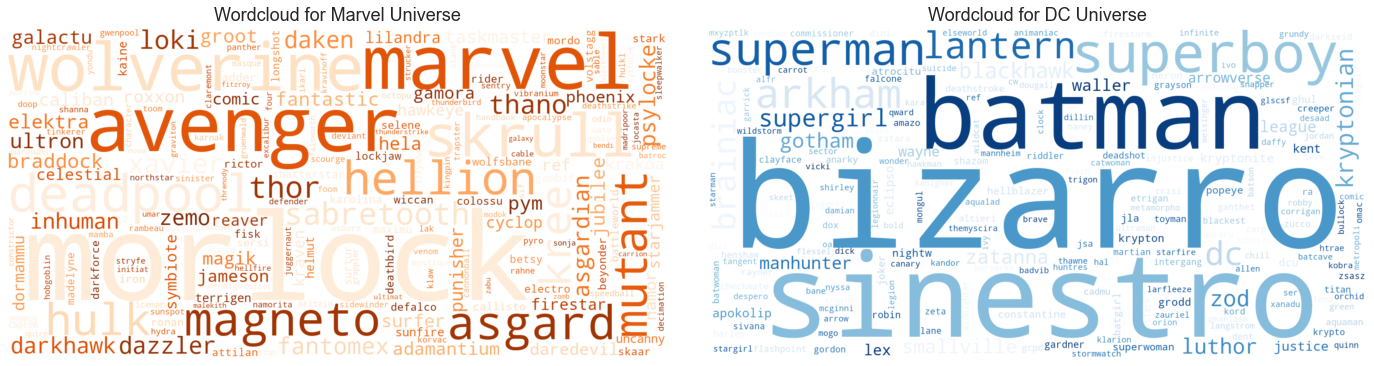

In [47]:
# Draw the word clouds:
plt.figure(figsize=[20, 20])

# Marvel wordcloud
plt.subplot(1, 2, 1)
wordcloud_marvel = WordCloud(width = 1600, 
                             height = 800, 
                             collocations = False, 
                             background_color = 'white', 
                             colormap = 'Oranges', 
                             random_state = 9).generate(string_marvel)
plt.imshow(wordcloud_marvel, interpolation = 'bilinear')
plt.title('Wordcloud for Marvel Universe', fontsize = 18, pad = 8.0)
plt.axis('off')

# DC wordcloud
plt.subplot(1, 2, 2)
wordcloud_dc = WordCloud(width = 1600, 
                         height = 800, 
                         collocations = False, 
                         background_color = 'white', 
                         colormap = 'Blues', 
                         random_state = 43).generate(string_dc)
plt.imshow(wordcloud_dc, interpolation = 'bilinear')
plt.title('Wordcloud for DC Universe', fontsize = 18, pad = 8.0)
plt.axis('off')
plt.tight_layout(pad = 4)
plt.show()

<span style="color:blue">What we can understand from these plots is that, indeed, the characters here seem to be both very popular in their own universe, but also unique to the respective universe in which they appear.</span>

<span style="color:blue">The results seem to be correct, considering that, for Marvel, many people discuss about Wolverine, Magneto, the Avengers, which are shown to be popular in our wordcloud. Similarly for DC: Batman, Superman, Green Lantern, Superboy are all very popular characters unique to their universe.</span>

---

<a id='3.'></a>
## Part 3: Community detection & TF-IDF Wordclouds

**Exercise 3**: Find communities and create associated TF-IDF word clouds (from lecture 7 and 8). In this exercise, we assume that you have been able to find communities in your network. It's OK to only work on a single universe in this one.

* Explain briefly how you chose to identify the communities: Which algorithm did you use, how does it work?

<span style="color:blue">We have chosen to maximize the modularity score for each community, through the use of the Louvain algorithm, which looks as how much more densely connected the nodes in a community are, compared to how connected the same nodes would be in a random network. The Louvain algorithm is an unsupervised clustering method, and allows finding of the best partition of nodes into communities from a full-scale graph.</span>

<span style="color:blue">The communities will be found upon the _undirected_ version of the Comics network.</span>

<br> 

___We will work upon the DC universe, for this notebook exercise.___

* How many communities did you find in total?

In order to find the best number of communities, we first have to create the undirected version of the DC universe (which is a subgraph of the Comics network):

In [48]:
# Make list of DC-character nodes
dc_nodes = [character_name for character_name, attr in comics_graph.nodes(data = True) if attr['universe'] == 'dc']
dc_graph = comics_graph.subgraph(dc_nodes)

# Create the undirected version of the DC universe graph
dc_graph = dc_graph.to_undirected()

Now, we will use the Python implemetation of the Louvain algorithm, together with a random seed for reproducibility purposes, in order to generate the partition which maximizes the modularity $M$ across all communities:

In [49]:
# Find the best community partition for the DC universe
partition_dc = community.best_partition(dc_graph, random_state = 3)

print("The Louvain algorithm has found", len(set(partition_dc.values())), "communities for DC universe.")

The Louvain algorithm has found 17 communities for DC universe.


__Optional visualization: <span style="color:blue">_Let us also try to visualize the community separation across the DC universe, using the Force-Atlas method:_</span>__

Even though we have made sure to remove isolated nodes completely earlier in the notebook, the Louvain algorithm sometimes creates some communities of 1-2 characters, because of their weak interaction with the rest of the universe. 

This is totally fine, and we will keep these communities and analyze them later on, however specifically for the purpose of visualizing the community separation, keeping them would result in the Force-Atlas algorithm being confused and placing nodes from these small communities at a very far distance from the central cluster, thus making the plot shrink undesirably.

Thus, only for this optional part, we will remove communities of less than 5 elements, and plot the major ones in the graph below:

In [50]:
# For this visualization, let's create a modifiable copy of the DC subgraph
viz_dc_graph = dc_graph.copy()

# Split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_dc.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_dc.items() if comm == community_nr]
    
    # The Force-Atlas methods needs removal of the communities with a very few number of elements
    if (len(dict_communities[community_nr]) < 5):
        viz_dc_graph.remove_nodes_from(dict_communities[community_nr])
        dict_communities.pop(community_nr)

We will work upon the undirected version of the DC universe graph, and compute the best node positions using Force-Atlas graph:

In [51]:
# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100)

positions = forceatlas2.forceatlas2_networkx_layout(viz_dc_graph, pos = None, iterations = 250)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:11<00:00, 21.65it/s]

BarnesHut Approximation  took  1.37  seconds
Repulsion forces  took  9.76  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


After we have found the most appropriate positions for every node in the graph, let us also make a color (and size) coding based on the __community partitioning__ found using the Louvain algorithm:

In [55]:
character_color_dict = {}
community_color_list = ['#00FA9A', '#0000FF', '#228B22', '#6495ED', '#FF1493', '#FFD700', '#4169E1', '#FF0000', '#7FFF00', '#808080', '#3DFA23', '#ABB351']

for community_nr, character_name_list in dict_communities.items():
    
    # For every node in this community, we assign them a previously-computed color
    for character_name in character_name_list:
        character_color_dict[character_name] = community_color_list[community_nr]
                
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_color_list = []
# At the same time, we will create a list of node sizes by looking directly at the degree of each individual node (within the undirected Comics network)
node_size_list = []

for node in viz_dc_graph:
    
    # Append the appropriate color to a node
    node_color_list.append(character_color_dict[node])

    # Append the appropriate size to a node
    node_size_list.append(viz_dc_graph.degree(node) * 0.6)

Finally, let us visualize the graph (using the Force-Atlas method):

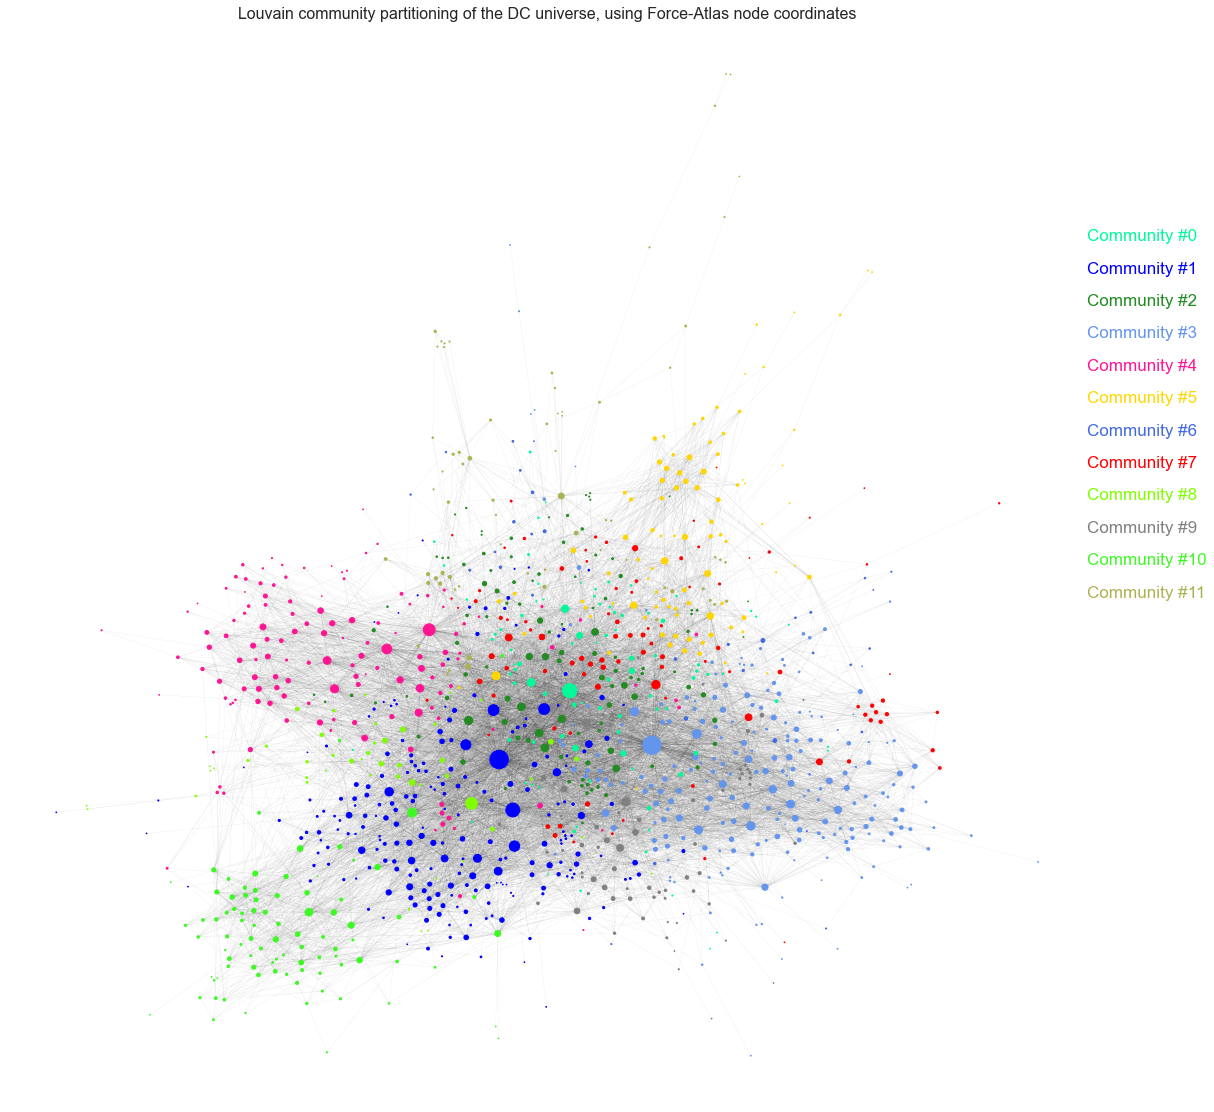

In [56]:
plt.figure(figsize = (15, 15))

nx.draw(viz_dc_graph, pos = positions, node_size = node_size_list, node_color = node_color_list, width = 0.025)

y = 0.80 # This is the starting Y, for the figure text
# Indicating community colors
for i in dict_communities.keys():
    plt.figtext(1, y, str('Community #' + str(i)), size = 17, color = community_color_list[i])
    y = y - 0.03

plt.title("Louvain community partitioning of the DC universe, using Force-Atlas node coordinates", fontsize = 16);

<span style="color:blue">The graph shows that the communities from the DC universe seem to interact a lot with each other, although nodes from a community will always interact most with other nodes from the same community, as per the modularity maximization principle which the Louvain algorithm used for finding the best partition.</span>

* Plot the distribution of community sizes.

For plotting the size distribution for communities, we will make use of the good-practice binning rules which have been investigated in the previous assignment:

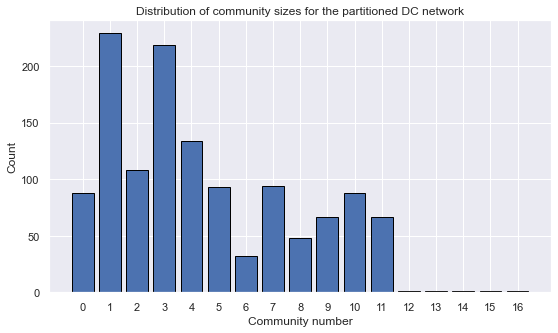

In [57]:
# Compute the size of each community
community_nr = list(partition_dc.values())

unique_nrs = np.unique(community_nr).tolist()
unique_nrs.append(unique_nrs[-1] + 1)

# Generate the histogram
hist, bin_edges = np.histogram(community_nr, bins = unique_nrs)

# Plot the distribution of sizes for each community, in a bar plot
with sns.axes_style("darkgrid"):
    plt.figure(figsize = [9, 5])
    plt.bar(bin_edges[:-1], hist, edgecolor = 'black')
    plt.xticks(range(min(unique_nrs), max(unique_nrs), 1))
    plt.xlabel('Community number')
    plt.ylabel('Count')
    plt.title('Distribution of community sizes for the partitioned DC network')
    plt.show()

<span style="color:blue">As we can see from the barplot above, it seems that we have 9 communities with reasonably large sizes of up to 250 characters in a community, while the other 4 communities are sparsely represented by only 1-2 members, most likely due to them having such little interaction with any other DC character from the network.</span>

* For the 5-10 largest communities, create TF-IDF based rankings of words in each community. There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.

Let's pick up the largest communities first:

In [189]:
# Let us split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_dc.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_dc.items() if comm == community_nr]

In [190]:
# Sort the community dictionary according to the size of each community 
rank = sorted(dict_communities, key=lambda k:len(dict_communities[k]), reverse = True)

# Pick the largest 10 communites
communities = {k:v for k, v in dict_communities.items() if k in rank[:10]}

Now, we will concatenate all the documents inside a community into one, for computational speed:

In [191]:
# Function for retriving all the documents and combine them into a single one for each community
def community_document(community=communities, id_path='data/dc'):
    # Create a dictionary for storing text of each community
    community_document_text = {}
    
    # Within each community
    for comm, _ in community.items():
        try:
            document_text = []
            for name in community.get(comm):
                # Generate the file path from the name of community
                path = os.path.join(os.getcwd(), id_path, (name+'.txt'))
                # Load file
                with open(path, 'r', encoding='utf-8') as f:
                    file = f.read()
                    document_text.append(file)
                
        except:
            pass
                
        community_document_text[comm] = ' '.join(document_text)
                    
    return community_document_text

In [192]:
# Dictionary with structure as {community : text}
community_document_text_dc = community_document()

Next, it is necessary to tokenize the original long texts into lists of words/tokens:

In [193]:
# Function for tokenizing the text into a list of words
def tokenize_text(text):
    # Replace all the HTML tags with ''
    text = re.sub(r'<\w+>', '', text)
    # Replace all the non-alphanumeric characters and numbers with space
    text = re.sub(r'[\W\_\d]', ' ', text)

    # Tokenize pages into individual strings
    words = text.split(' ')
    
    # Remove all the punctuations and stopwords, set words to lower-case and lemmatize the words
    wnl = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = [wnl.lemmatize(word.lower()) for word in words 
             if word not in StringLibrary.punctuation
             if word not in stop_words]
    
    return words

The term frequency will be computed using different weighting methods:

In [194]:
# Function for computing term-frequency
def community_term_frequency(community_document_text, tf_method='term_frequency'):
    # Creating a dictionary for storing term counts of each community
    community_term_count = {} 
    # Creating a dictionary for storing term frequency of each community
    community_term_frequency = {}
    
    # Get text from each community
    for comm, text in community_document_text.items():
        community_term_frequency[comm] = {}
        community_term_count[comm] = {}
        
        # Tokenize the text into a list of words
        words = tokenize_text(text)
        
        # Count the occurrence of each word
        for word in words:
            if word not in community_term_count[comm].keys():
                community_term_count[comm][word] = 1
            else:
                community_term_count[comm][word] += 1
    
    
        # Compute different types of term frequency
        if tf_method == 'raw_count':
            return community_term_count

        elif tf_method == 'term_frequency':
            community_term_frequency[comm] = {k:v/len(community_document_text[comm]) for k,v in community_term_count[comm].items()}

        elif tf_method == 'log':
            community_term_frequency[comm] = {k:math.log(1 + v) for k,v in community_term_count[comm].items()}

        elif tf_method == 'double_normalization':
            community_term_frequency[comm] = {k:(0.5 + 0.5*v/max(community_term_count[comm].values())) 
                                              for k,v in community_term_count[comm].items()}

    return community_term_frequency

In [195]:
# Dictionary with structure as {community : {word : term frequency}} 
community_term_frequency_dc = community_term_frequency(community_document_text = community_document_text_dc)

Numerous ways of calculating the weights of terms can be applied, as shown in the function above:

* __Raw count__: This method simply counts the occurrence of each word.

* __Term frequency__: This method takes the total number of words of each document into account. For instance, if the counts of a word is high, but not high comparing to the total amount of words shown in a text, then this word is likely to not be too important.

* __Log__: This method uses the logarithm scale, which manages to shrink the difference of weights between highly frequent words and less frequent ones.

* __Double normalization__: This method aims to mitigate the case that we observe higher term frequencies in longer documents, merely because longer documents tend to repeat the same words over and over again.

<font color='blue'> We chose to use ___term frequency___ ( adjusted for document length) for our scenario, since it modifies the original frequency (i.e. raw counts) by considering the length of texts, because the wiki content of each character varies significantly. Therefore, in order to avoid words to have a higher weight merely because they appear more in longer texts, adjustments were made according to document length. </font>

Here, after the Term Frequency is computed, we need to also compute the Inverse Document Frequency:

In [196]:
# Function for computing inverse-document-frequency
def community_inverse_document_frequency(community_document_text, community_term_frequency, idf_method='idf_smooth'):
    # Total number of documents
    N = len(community_document_text)
    
    community_inverse_document_frequency = {}
    
    # Create a nested dictionary {community : {word : 0}} for storing idf score in it afterwards
    for comm1 in community_term_frequency.keys():
        community_inverse_document_frequency[comm1] =  {k:0 for k in community_term_frequency[comm1].keys()}

        # For each word in one specific community, find how many times this word shown in other communities
        for word in community_term_frequency[comm1]:
            for comm2 in community_term_frequency.keys():
                if word in community_term_frequency[comm2].keys():
                    community_inverse_document_frequency[comm1][word] += 1
        
        # Compute different types of inverse document frequency 
        if idf_method == 'idf':
            community_inverse_document_frequency[comm1] = {k:math.log(N/v) for k, v in community_inverse_document_frequency[comm1].items()}
        elif idf_method == 'idf_smooth':
            community_inverse_document_frequency[comm1] = {k:(math.log(N/(1+v))+1) for k, v in community_inverse_document_frequency[comm1].items()}

    return community_inverse_document_frequency

In [197]:
# Dictionary with structure as {community : {word : inverse document frequency}} 
community_inverse_document_frequency_dc = community_inverse_document_frequency(community_document_text_dc, community_term_frequency_dc)

Inverse document frequency (IDF) measures how common a word is across all the documents. 

Here we will implement two ways of calculating IDF scores: 

* __idf__: This method calculates the IDF score directly using the logarithm of the ratio $\frac{N}{n_t}$, where $N$ denotes the total number of documents and $n_t$ denotes the number of documents where the word occurs in. If the IDF score is low, it means that the word is not only common in one document, but it also tends to show up in several documents which suggests that this word might not be informative.

* __idf_smooth__: This method is a modified version of original IDF to solve the situation when the word occurs 0 times.

TF-IDF considers TF and IDF together by multiplying this two terms word-wise (TF shows how frequently a word occurs, while IDF could help to see whether the word is unique or not in corpus).

Let us compute the TF-IDF scores for our communities below:

In [198]:
# Function for computing TF-IDF score
def community_tf_idf(community_term_frequency, community_inverse_document_frequency):
    community_tf_idf = {}
    for comm in community_term_frequency:
        # Calculate TF-IDF score by multiplying TF score and IDF score
        community_tf_idf[comm] = {k:v*community_term_frequency[comm][k] for k,v in community_inverse_document_frequency[comm].items()}
    
    return community_tf_idf

In [199]:
# Dictionary with structure as {community : {word : TF-IDF score}} 

community_tf_idf_dc = community_tf_idf(community_term_frequency_dc, community_inverse_document_frequency_dc)

* Create a word-cloud displaying the most important words in each community (according to TF-IDF). Comment on your results (do they make sense according to what you know about the superhero characters in those communities?)

Now we generate the wordcloud for each community:

In [69]:
# Function for converting the word dictionary into a string
def dict_to_string(word_dict, shrink=True):
    
    total_string = ''
    
    for word in word_dict:
        
        # If the counts of words are too large, we divide the original count by 10 for computing faster
        if shrink==True:
            repeat_nr = math.ceil(word_dict[word] / 100)
        
        else:
            repeat_nr = math.ceil(word_dict[word])
        
        # Create a string of one term (occuring, in a proportional manner, according to the TF-TR scores)
        string = ''.join([word+' ' for count in range(repeat_nr)])
        
        # Concatenate the current elements to the total string
        total_string += string
        
    return total_string

In [72]:
string = {}
wordclouds = []
for comm in community_tf_idf_dc.keys():
    
    string[comm] = dict_to_string(community_tf_idf_dc[comm], False)
    
    wordcloud = WordCloud(width = 1600, 
                          height = 800, 
                          collocations = False, 
                          background_color = 'white',
                          random_state = 29).generate(string[comm])
    wordclouds.append(wordcloud)

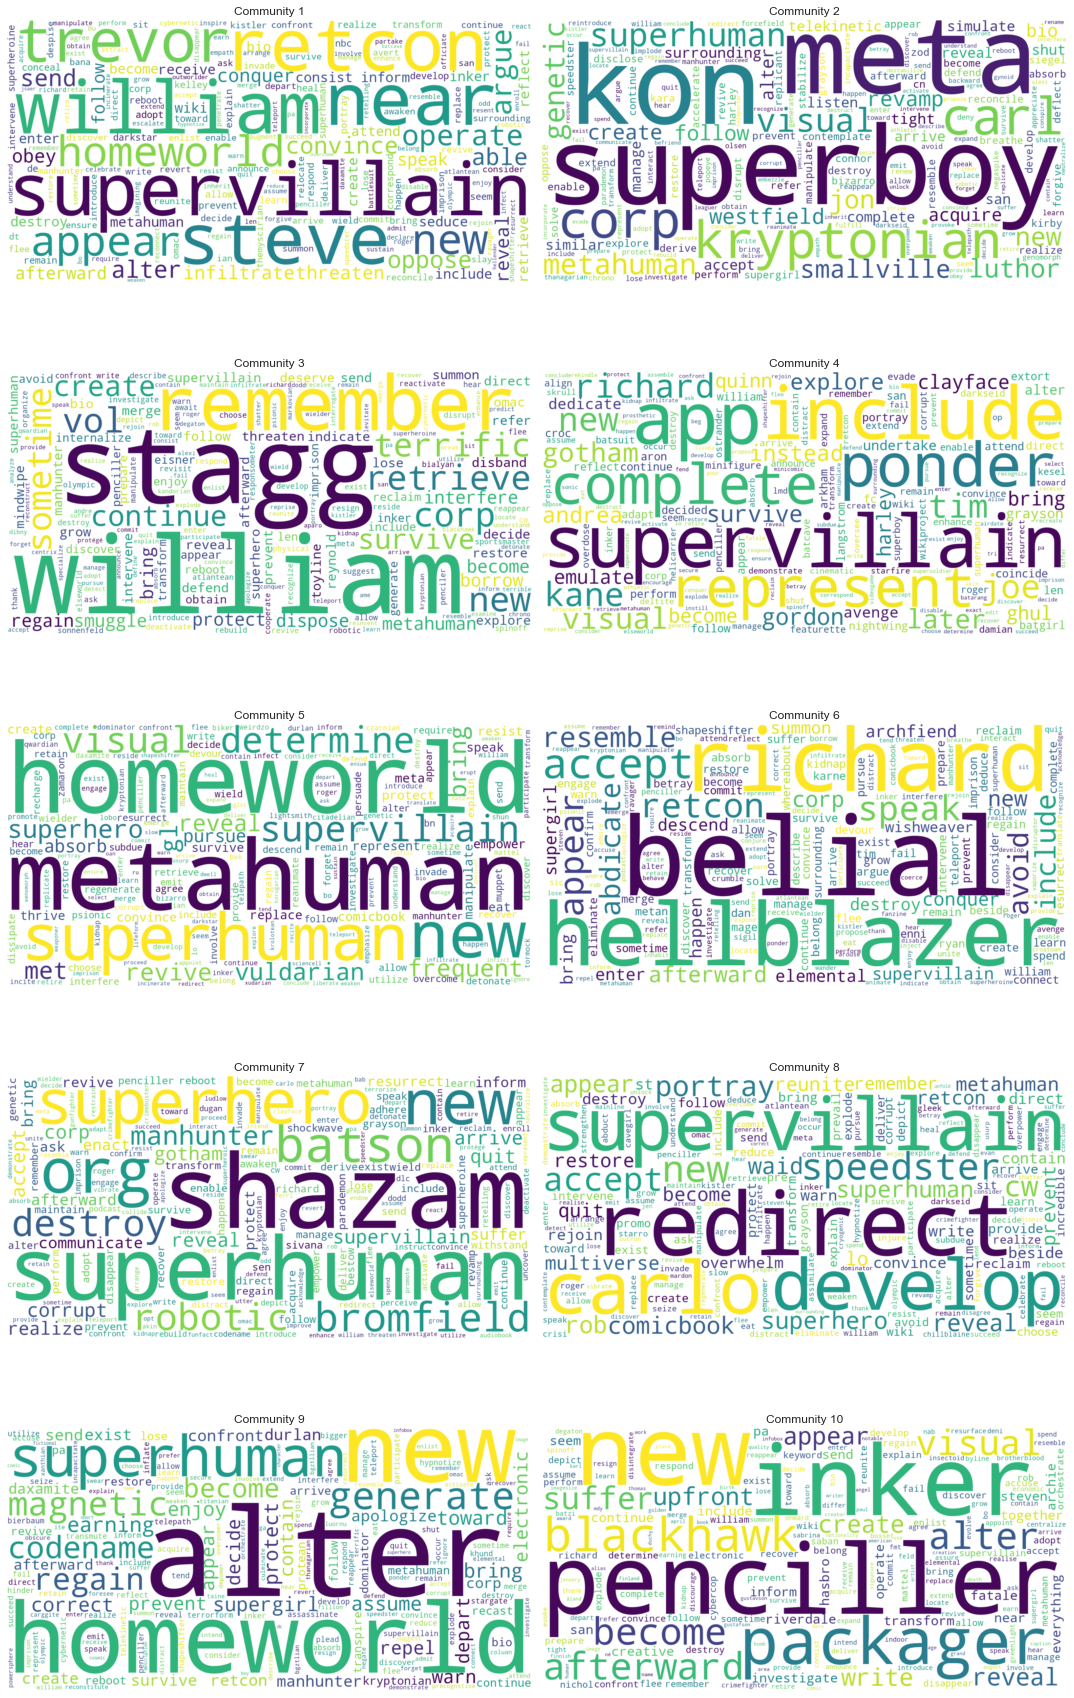

In [75]:
# Display the generated images
fig, axs = plt.subplots(5, 2,figsize=(15,25))
axs[0, 0].imshow(wordclouds[0], interpolation='bilinear')
axs[0, 0].set_title('Community 1')
axs[0, 0].axis('off')

axs[0, 1].imshow(wordclouds[1], interpolation='bilinear')
axs[0, 1].set_title('Community 2')
axs[0, 1].axis('off')

axs[1, 0].imshow(wordclouds[2], interpolation='bilinear')
axs[1, 0].set_title('Community 3')
axs[1, 0].axis('off')

axs[1, 1].imshow(wordclouds[3], interpolation='bilinear')
axs[1, 1].set_title('Community 4')
axs[1, 1].axis('off')

axs[2, 0].imshow(wordclouds[4], interpolation='bilinear')
axs[2, 0].set_title('Community 5')
axs[2, 0].axis('off')

axs[2, 1].imshow(wordclouds[5], interpolation='bilinear')
axs[2, 1].set_title('Community 6')
axs[2, 1].axis('off')

axs[3, 0].imshow(wordclouds[6], interpolation='bilinear')
axs[3, 0].set_title('Community 7')
axs[3, 0].axis('off')

axs[3, 1].imshow(wordclouds[7], interpolation='bilinear')
axs[3, 1].set_title('Community 8')
axs[3, 1].axis('off')

axs[4, 0].imshow(wordclouds[8], interpolation='bilinear')
axs[4, 0].set_title('Community 9')
axs[4, 0].axis('off')

axs[4, 1].imshow(wordclouds[9], interpolation='bilinear')
axs[4, 1].set_title('Community 10')
axs[4, 1].axis('off')

plt.tight_layout(pad = 1)

<font color='blue'> These results are very relevant for the DC communities that we have identified, as the wordclouds describe what is unique about the pages of each community. </font>

<font color='blue'> For example, we can most likely say that Community 2 is where Superman and Lex Luthor reside, since one of the most important discussed topics is _kryptonite_. Each of these wordclouds are somehow a mirror of the key events and people which are talked about inside that community, and by looking at each and every one of them, we can see that they are quite different. </font>

<font color='blue'> Lastly, it can be clearly seen that topics such as 'superhuman', 'metahuman' and 'supervillain' are important discussions across most communities, even if they are written using slightly different words for each community. </font>

---

<a id='4.'></a>
## Part 4: Sentiment analysis of communities

**Exercise 4**: Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities. Unlike above - we work all communities. It's still OK to work with data from a single universe. More tips & tricks can be found, if you take a look at Lecture 8's exercises.

In this exercise the LabMT wordlist will be used as a reference dictionary to look up word average happiness score for the words of the pages/nodes from the DC universe.

**_A brief description of the LabMT wordlist:_**

The raw texts are composed 4 disparate text sources: Twitter, Google Books, music lyrics and the New York times. Wordlist extracted from the text sources are ordered by decreasing frequency of occurrence. Top 5000 words from each of the text sources are merged to form a set of 10222 unique words.

Amazon's Mechanical Turk evaluations were used to define the happiness level of words extracted from the text sources, which rates the words on a 9 point scale.

In [77]:
# Take a look at the LabMt wordlist
LabMT = pd.read_csv('./LabMT.txt', sep="\t", skiprows = 2)
LabMT

word  happiness_rank  happiness_average  \
0       laughter               1               8.50   
1      happiness               2               8.44   
2           love               3               8.42   
3          happy               4               8.30   
4        laughed               5               8.26   
...          ...             ...                ...   
10217     murder           10218               1.48   
10218  terrorism           10219               1.48   
10219       rape           10220               1.44   
10220    suicide           10221               1.30   
10221  terrorist           10222               1.30   

       happiness_standard_deviation twitter_rank google_rank nyt_rank  \
0                            0.9313         3600          --       --   
1                            0.9723         1853        2458       --   
2                            1.1082           25         317      328   
3                            0.9949           65        1372     1313   
4                            1.1572         3334        3542       --   
...                             ...          ...         ...      ...   
10217                        1.0150         2762        3110     1541   
10218                        0.9089           --          --     3192   
10219                        0.7866         3133          --     4115   
10220                        0.8391         2124        4707     3319   
10221                        0.9091         3576          --     3026   

      lyrics_rank  
0            1728  
1            1230  
2              23  
3             375  
4            2332  
...           ...  
10217        1059  
10218          --  
10219        2977  
10220        2107  
10221          --  

[10222 rows x 8 columns]

In [78]:
# Create a word happiness score look up dictionary using LabMT 
labmt = pd.Series(LabMT.happiness_average.values,index=LabMT.word.values).to_dict()

Now we will extract all pages from the DC graph:

In [79]:
v = list(dc_graph.nodes())

corpus_dc = {}
for char in v:
    filename = str(char)+'.txt'
    filepath = os.path.join(os.getcwd(), "data/dc", filename)
    try:
        with open(filepath,encoding = 'utf-8') as f_input:
            corpus_dc[char] = (f_input.read())
    except:
        print('failed for', char)

And tokenize all the pages for later analysis:

In [80]:
tokens = {}
for k,v in corpus_dc.items():
    print
    tokens[k] = list(set([w.lower() for w in cleaning_text_corpus(corpus_dc[k]) if w.isalpha()]))
print('There are in total', len(tokens.keys()), 'nodes/pages.')

There are in total 1272 nodes/pages.


* Calculate and store sentiment for every single page. 

In [81]:
# Create a function that calculate sentiment given a list of tokens
def sentiment(tokens):
    
    ## find word hapiness score by looking up the labmt dictionary 
    hw = {k:v for k,v in labmt.items() if k in tokens}
    
    ## sort hw by key values
    HW = dict(sorted(hw.items()))
    
    ## create frequency distribution of the token 
    text = nltk.Text(tokens)
    text_freq = nltk.FreqDist(text)
    
    ## normalize term frequency 
    sum_f = sum(text_freq.values())
    pi = {k:v/sum_f for k,v in text_freq.items()}
    
    ## sort pi by key values 
    PI = dict(sorted(pi.items()))
    
    ## calculate sentiment 
    sen = sum(HW[k]*PI[k] for k in HW)
    
    return sen 

In [82]:
# Create the sentiment list for every page
sentiment_list = {}

for k,v in tokens.items():
    sentiment_list[k] = sentiment(tokens[k])

* Create a histogram of all character's associated page-sentiments.

In [83]:
sentiments = sorted([v for k,v in sentiment_list.items()],reverse = True)
sentimentscount = collections.Counter(sentiments)
sent, count = zip(*sentimentscount.items())

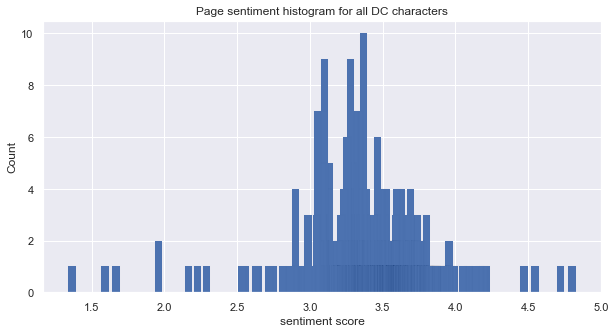

In [84]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = [10, 5])
    plt.bar(sent, count, width=0.05, edgecolor = 'black',linewidth=0.01)
    plt.xlabel('sentiment score')
    plt.ylabel('Count')
    plt.title('Page sentiment histogram for all DC characters')
    plt.show()

<font color='blue'> As we can see from the histograms, majority of sentiments of character pages lies slightly below the neutral level of happiness score, with few above and few below. It can be interpreted that as the content of the two comics involving frequent actions, wars, conflicts within their storylines, word choices of these comics would generally be rated as less "happy". Moreover, it is to note that none of the page sentiments had scores above 5.0 as the text sources are from wikipages that are known to be written in as neutral tones as possible. 

* What are the 10 characters with happiest and saddest pages?

In [165]:
# Sort the character-sentiment list according to their sentiment score
char_sentiment = sorted(sentiment_list.items(),key=lambda x: x[1],reverse = True)

print('The 10 characters with the happiest pages are: \n')

for i in range(10):
    print('#' + str(i+1) + ":", char_sentiment[i])

The 10 characters with the happiest pages are 

#1: ('Doctor Trap', 4.801818181818182)
#2: ('Weather Witch', 4.7225)
#3: ('Rose Psychic', 4.548)
#4: ('Billy the Kid', 4.4725)
#5: ('Fausta Grables', 4.2164705882352935)
#6: ('Terry Berg', 4.2075000000000005)
#7: ('Killer Wasp', 4.196363636363637)
#8: ('White Magician', 4.194)
#9: ('Buzz', 4.174424778761061)
#10: ('Jacob Kane', 4.167902097902097)


In [166]:
print('The 10 characters with the saddest pages are: \n')

for i in range(len(char_sentiment) - 10, len(char_sentiment)):
    print('#' + str(len(char_sentiment) - i) + ":", char_sentiment[i])

The 10 characters with the saddest pages are 

#10: ('Harold Allnut', 2.5330434782608697)
#9: ('Tess Mercer', 2.2914285714285714)
#8: ('Nebiros', 2.229406779661017)
#7: ('Mnemoth', 2.2279999999999998)
#6: ('Prince Evillo', 2.165)
#5: ('Time Trapper', 1.9575)
#4: ('Byth', 1.9575)
#3: ('Gorilla Boss', 1.6685714285714284)
#2: ('Davis Bloome', 1.5914285714285712)
#1: ('Lion-Mane', 1.365)


<font color='blue'> The happiest and saddest pages are mostly quite short which means they contain less information and few positive words and negative words will have greater influence on their sentiment scores. For example, the description of Lion-Mane is one sentence but already contains 'fought', 'expelled' and 'possessed'. On the other hand, Doctor Trap received high score because another reason which is that a lot of key words in its description was not contained in the LabMT wordlist, leaving few rather neutral words and thus higher sentiment score. 

* What are the three happiest communities?

In [167]:
avg_sent = {}
for com in dict_communities.keys():
    avg_sent[com] = np.mean([v for k,v in sentiment_list.items() if k in dict_communities[com]])

In [168]:
# Rename the avg_sent list 
for com in dict_communities.keys():
    new_name = list(zip(*sorted(dict(dc_graph.degree(dict_communities[com])).items(),key=lambda x: x[1],reverse = True)[:3]))[0]
    avg_sent[new_name] = avg_sent.pop(com)
print('The community sentiment lists named after their three most connected characters are \n')
avg_sent

The community sentiment lists named after their three most connected characters are 



{('Wonder Woman', 'Donna Troy', 'Animal Man'): 3.5205853349124037,
 ('Superman', 'Lex Luthor', 'Green Arrow'): 3.438072880962644,
 ('Booster Gold', 'Maxwell Lord', 'Red Tornado'): 3.467927932539141,
 ('Batman', 'Deathstroke', 'Black Canary'): 3.4331548423148917,
 ('Green Lantern', 'Hal Jordan', 'Sinestro'): 3.387782282193497,
 ('Power Girl', 'Phantom Stranger', 'Felix Faust'): 3.461470210471261,
 ('Rhea Jones', 'Monsieur Mallah', 'Beast Boy(II)'): 3.4944131752174306,
 ('Black Adam', 'Eclipso', 'Batwoman'): 3.4876784007196537,
 ('Darkseid', 'Big Barda', 'Granny Goodness'): 3.408243068756532,
 ('Gorilla Grodd', 'Vandal Savage', 'Wally West'): 3.487185423062332,
 ('Superboy-Prime', 'Brainiac 5', 'Saturn Girl'): 3.4293063684425493,
 ('Quality Comics', 'Doctor Polaris', 'Mattel'): 3.530187717138839,
 ('Blizzard',): 3.2636241610738255,
 ('Bliss',): 3.063636363636364,
 ('Volcana',): 3.4,
 ('Blackwing',): 3.668473520249222,
 ('8-Ball',): 3.2976470588235296}

In [176]:
community_sentiment = sorted(avg_sent.items(),key=lambda x: x[1],reverse = True)

In [186]:
print('The 3 happiest communities are: \n')

for i in range(3):
    print('#' + str(i+1) + ":", community_sentiment[i][0], ':', community_sentiment[i][1])

The 3 happiest communities are: 

#1: ('Blackwing',) : 3.668473520249222
#2: ('Quality Comics', 'Doctor Polaris', 'Mattel') : 3.530187717138839
#3: ('Wonder Woman', 'Donna Troy', 'Animal Man') : 3.5205853349124037


* What are the three saddest communities?

In [187]:
print('The 3 saddest communities are: \n')

for i in range(len(community_sentiment) - 3, len(community_sentiment)):
    print('#' + str(len(community_sentiment) - i) + ":", community_sentiment[i][0], ':', community_sentiment[i][1])

The 3 saddest communities are: 

#3: ('8-Ball',) : 3.2976470588235296
#2: ('Blizzard',) : 3.2636241610738255
#1: ('Bliss',) : 3.063636363636364


* Do these results confirm what you can learn about each community by skimming the wikipedia pages?

<font color='blue'> The results overall makes sense. For example, "8-Ball" only has a 1-line description and already contains twice the word 'bullets' which gives it a low sentiment score, blizzard itself is a "unhappy" word. 'bliss' has a relatively darker description which also makes sense. Moreover, for the happiest communitites words in the Wikipedia pages tends to be less aggresive or extreme. However, it is important to point out that due to the nature of wikipedia pages being quite neutral, there are very limited difference in sentiment scores of the communities. Another limitation is shown by the words in the descriptions of the comics pages are not very general use words, thus does not appear in the LabMT list. 